# Advanced Lesion Pattern Analysis

This notebook performs advanced analysis of lesion patterns including:
- Population-level lesion frequency mapping
- Lesion clustering and pattern identification
- Statistical analysis of lesion-deficit relationships
- Volume-based analysis

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy import stats
from pathlib import Path
import sys
import warnings

warnings.filterwarnings("ignore")

# Add src to path
sys.path.append("../src")

from visualization import BrainLesionVisualizer
from analysis_dashboard import BrainLesionAnalyzer

%matplotlib inline

## Initialize Analysis Tools

In [2]:
# Initialize visualizer and analyzer
data_root = Path("../data")
visualizer = BrainLesionVisualizer(data_root)
analyzer = BrainLesionAnalyzer(visualizer)

tasks_df = visualizer.tasks_df

print("Analysis tools initialized successfully!")
print(f"Total patients: {len(tasks_df)}")

Analysis tools initialized successfully!
Total patients: 4119


## Lesion Volume Analysis

In [3]:
# Calculate lesion volumes for analysis
print("Calculating lesion volumes for subset of patients...")

# Start with patients who have deficits for more interesting analysis
deficit_patients = tasks_df[tasks_df["Clinical score"] > 0].sample(
    n=min(100, len(tasks_df[tasks_df["Clinical score"] > 0])), random_state=42
)

volumes = []
valid_patients = []

for _, row in deficit_patients.iterrows():
    try:
        volume = visualizer.calculate_lesion_volume(row["lesion_id"])
        volumes.append(volume)
        valid_patients.append(row)
    except FileNotFoundError:
        continue

volume_analysis_df = pd.DataFrame(valid_patients)
volume_analysis_df["volume"] = volumes

print(f"Volume analysis completed for {len(volume_analysis_df)} patients")
print(f"Mean volume: {np.mean(volumes):.0f} voxels")
print(f"Volume range: {np.min(volumes):.0f} - {np.max(volumes):.0f} voxels")

Calculating lesion volumes for subset of patients...
Volume analysis completed for 100 patients
Mean volume: 3227 voxels
Volume range: 6 - 26513 voxels


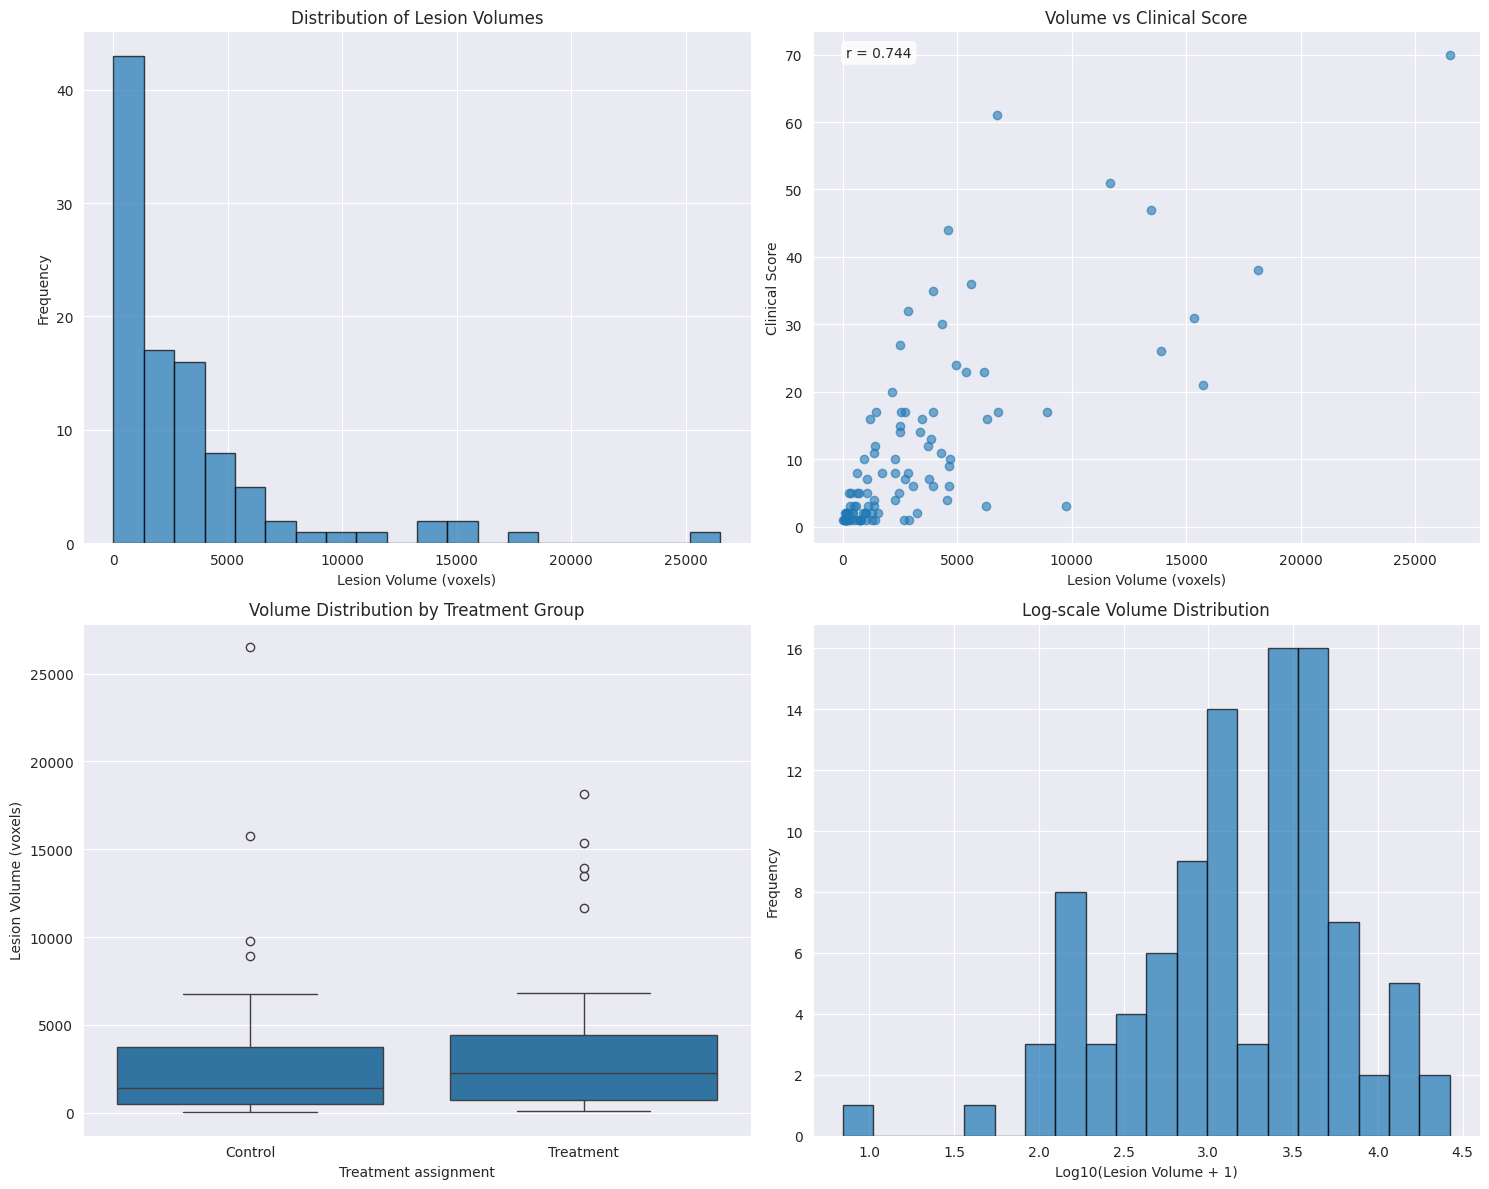


Volume Statistics:
Mean: 3227 voxels
Median: 1642 voxels
Standard deviation: 4317 voxels
Volume-Clinical correlation: 0.744


In [4]:
# Volume distribution analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Volume histogram
axes[0, 0].hist(volumes, bins=20, alpha=0.7, edgecolor="black")
axes[0, 0].set_xlabel("Lesion Volume (voxels)")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].set_title("Distribution of Lesion Volumes")

# Volume vs Clinical Score
axes[0, 1].scatter(
    volume_analysis_df["volume"], volume_analysis_df["Clinical score"], alpha=0.6
)
axes[0, 1].set_xlabel("Lesion Volume (voxels)")
axes[0, 1].set_ylabel("Clinical Score")
axes[0, 1].set_title("Volume vs Clinical Score")

# Add correlation coefficient
correlation = volume_analysis_df["volume"].corr(volume_analysis_df["Clinical score"])
axes[0, 1].text(
    0.05,
    0.95,
    f"r = {correlation:.3f}",
    transform=axes[0, 1].transAxes,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
)

# Volume by treatment group (if available)
treatment_volume = volume_analysis_df[
    volume_analysis_df["Treatment assignment"].isin(["Treatment", "Control"])
]
if len(treatment_volume) > 0:
    sns.boxplot(
        data=treatment_volume, x="Treatment assignment", y="volume", ax=axes[1, 0]
    )
    axes[1, 0].set_title("Volume Distribution by Treatment Group")
    axes[1, 0].set_ylabel("Lesion Volume (voxels)")
else:
    axes[1, 0].text(
        0.5,
        0.5,
        "No treatment data available",
        ha="center",
        va="center",
        transform=axes[1, 0].transAxes,
    )
    axes[1, 0].set_title("Volume by Treatment (No Data)")

# Log-scale volume distribution
log_volumes = np.log10(np.array(volumes) + 1)  # Add 1 to avoid log(0)
axes[1, 1].hist(log_volumes, bins=20, alpha=0.7, edgecolor="black")
axes[1, 1].set_xlabel("Log10(Lesion Volume + 1)")
axes[1, 1].set_ylabel("Frequency")
axes[1, 1].set_title("Log-scale Volume Distribution")

plt.tight_layout()
plt.show()

# Statistical summary
print("\nVolume Statistics:")
print(f"Mean: {np.mean(volumes):.0f} voxels")
print(f"Median: {np.median(volumes):.0f} voxels")
print(f"Standard deviation: {np.std(volumes):.0f} voxels")
print(f"Volume-Clinical correlation: {correlation:.3f}")

## Population Lesion Frequency Analysis

In [5]:
# Analyze lesion frequency patterns across population
print("Analyzing population lesion patterns...")

# Sample subset for computational efficiency
sample_patients = tasks_df[tasks_df["Clinical score"] > 0].sample(
    n=min(50, len(tasks_df[tasks_df["Clinical score"] > 0])), random_state=42
)

# Initialize frequency map
frequency_map = np.zeros((91, 109, 91))
valid_count = 0

print(f"Processing {len(sample_patients)} patients...")

for _, row in sample_patients.iterrows():
    try:
        lesion_data = visualizer.load_lesion(row["lesion_id"])
        frequency_map += lesion_data
        valid_count += 1

        if valid_count % 10 == 0:
            print(f"Processed {valid_count} patients...")

    except FileNotFoundError:
        continue

# Normalize to frequencies
if valid_count > 0:
    frequency_map = frequency_map / valid_count
    print(f"\nFrequency map created from {valid_count} patients")
    print(f"Maximum frequency: {np.max(frequency_map):.3f}")
    print(f"Number of voxels with any lesions: {np.sum(frequency_map > 0)}")
else:
    print("No valid lesion data found")

Analyzing population lesion patterns...
Processing 50 patients...
Processed 10 patients...
Processed 20 patients...
Processed 30 patients...
Processed 40 patients...
Processed 50 patients...

Frequency map created from 50 patients
Maximum frequency: 0.180
Number of voxels with any lesions: 74336


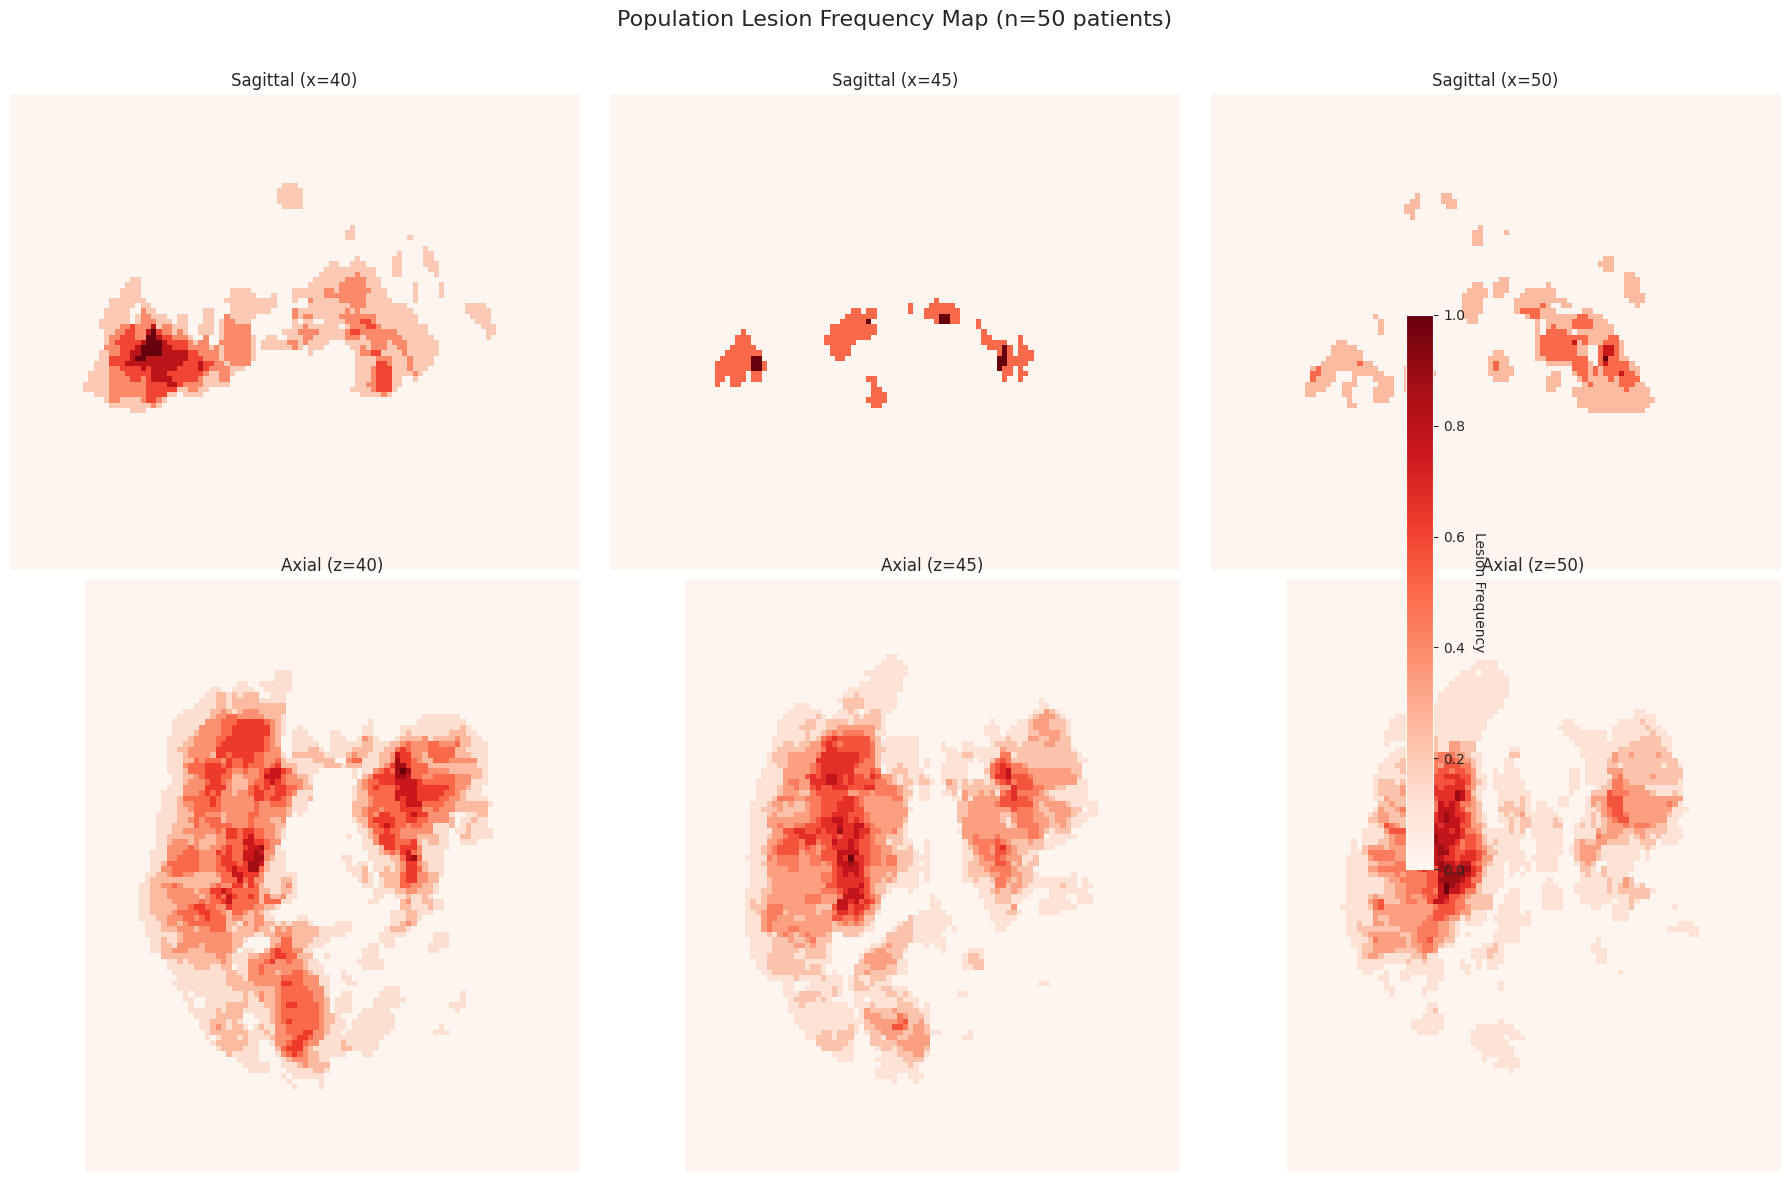

In [6]:
# Visualize frequency patterns
if valid_count > 0:
    # Select different slice orientations
    center_x = frequency_map.shape[0] // 2
    center_y = frequency_map.shape[1] // 2
    center_z = frequency_map.shape[2] // 2

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Sagittal slices
    axes[0, 0].imshow(frequency_map[center_x - 5, :, :].T, cmap="Reds", origin="lower")
    axes[0, 0].set_title(f"Sagittal (x={center_x-5})")
    axes[0, 0].axis("off")

    axes[0, 1].imshow(frequency_map[center_x, :, :].T, cmap="Reds", origin="lower")
    axes[0, 1].set_title(f"Sagittal (x={center_x})")
    axes[0, 1].axis("off")

    axes[0, 2].imshow(frequency_map[center_x + 5, :, :].T, cmap="Reds", origin="lower")
    axes[0, 2].set_title(f"Sagittal (x={center_x+5})")
    axes[0, 2].axis("off")

    # Axial slices
    axes[1, 0].imshow(frequency_map[:, :, center_z - 5].T, cmap="Reds", origin="lower")
    axes[1, 0].set_title(f"Axial (z={center_z-5})")
    axes[1, 0].axis("off")

    axes[1, 1].imshow(frequency_map[:, :, center_z].T, cmap="Reds", origin="lower")
    axes[1, 1].set_title(f"Axial (z={center_z})")
    axes[1, 1].axis("off")

    axes[1, 2].imshow(frequency_map[:, :, center_z + 5].T, cmap="Reds", origin="lower")
    axes[1, 2].set_title(f"Axial (z={center_z+5})")
    axes[1, 2].axis("off")

    # Add colorbar
    cbar = plt.colorbar(
        plt.cm.ScalarMappable(cmap="Reds"), ax=axes, shrink=0.6, aspect=20
    )
    cbar.set_label("Lesion Frequency", rotation=270, labelpad=15)

    plt.suptitle(
        f"Population Lesion Frequency Map (n={valid_count} patients)", fontsize=16
    )
    plt.tight_layout()
    plt.show()
else:
    print("Cannot visualize frequency map - no valid data")

## Lesion Pattern Clustering

In [7]:
# Perform lesion pattern clustering
print("Performing lesion pattern clustering analysis...")
print("Note: This analysis uses a subset of patients for computational efficiency")

# Use subset for clustering
clustering_patients = tasks_df[tasks_df["Clinical score"] > 0].sample(
    n=min(30, len(tasks_df[tasks_df["Clinical score"] > 0])), random_state=42
)

# Collect lesion data
lesion_vectors = []
valid_patient_data = []

for _, row in clustering_patients.iterrows():
    try:
        lesion_data = visualizer.load_lesion(row["lesion_id"])
        lesion_vector = lesion_data.flatten()
        lesion_vectors.append(lesion_vector)
        valid_patient_data.append(row)
    except FileNotFoundError:
        continue

if len(lesion_vectors) > 5:  # Need minimum patients for clustering
    lesion_matrix = np.array(lesion_vectors)
    clustering_df = pd.DataFrame(valid_patient_data)

    print(f"Clustering {len(lesion_vectors)} lesion patterns")

    # Apply PCA for dimensionality reduction
    n_components = min(10, len(lesion_vectors) - 1)
    pca = PCA(n_components=n_components, random_state=42)
    lesion_pca = pca.fit_transform(lesion_matrix)

    print(f"PCA explained variance ratio: {pca.explained_variance_ratio_[:5]}")

    # Apply K-means clustering
    n_clusters = min(4, len(lesion_vectors) // 3)  # Ensure reasonable cluster sizes
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(lesion_pca)

    clustering_df["Cluster"] = cluster_labels

    print(f"Created {n_clusters} clusters")
    print("Cluster sizes:", np.bincount(cluster_labels))

else:
    print(
        f"Insufficient data for clustering (only {len(lesion_vectors)} valid lesions)"
    )
    clustering_df = None

Performing lesion pattern clustering analysis...
Note: This analysis uses a subset of patients for computational efficiency
Clustering 30 lesion patterns
PCA explained variance ratio: [0.22505257 0.13465409 0.08884603 0.08510737 0.06458619]
Created 4 clusters
Cluster sizes: [27  1  1  1]


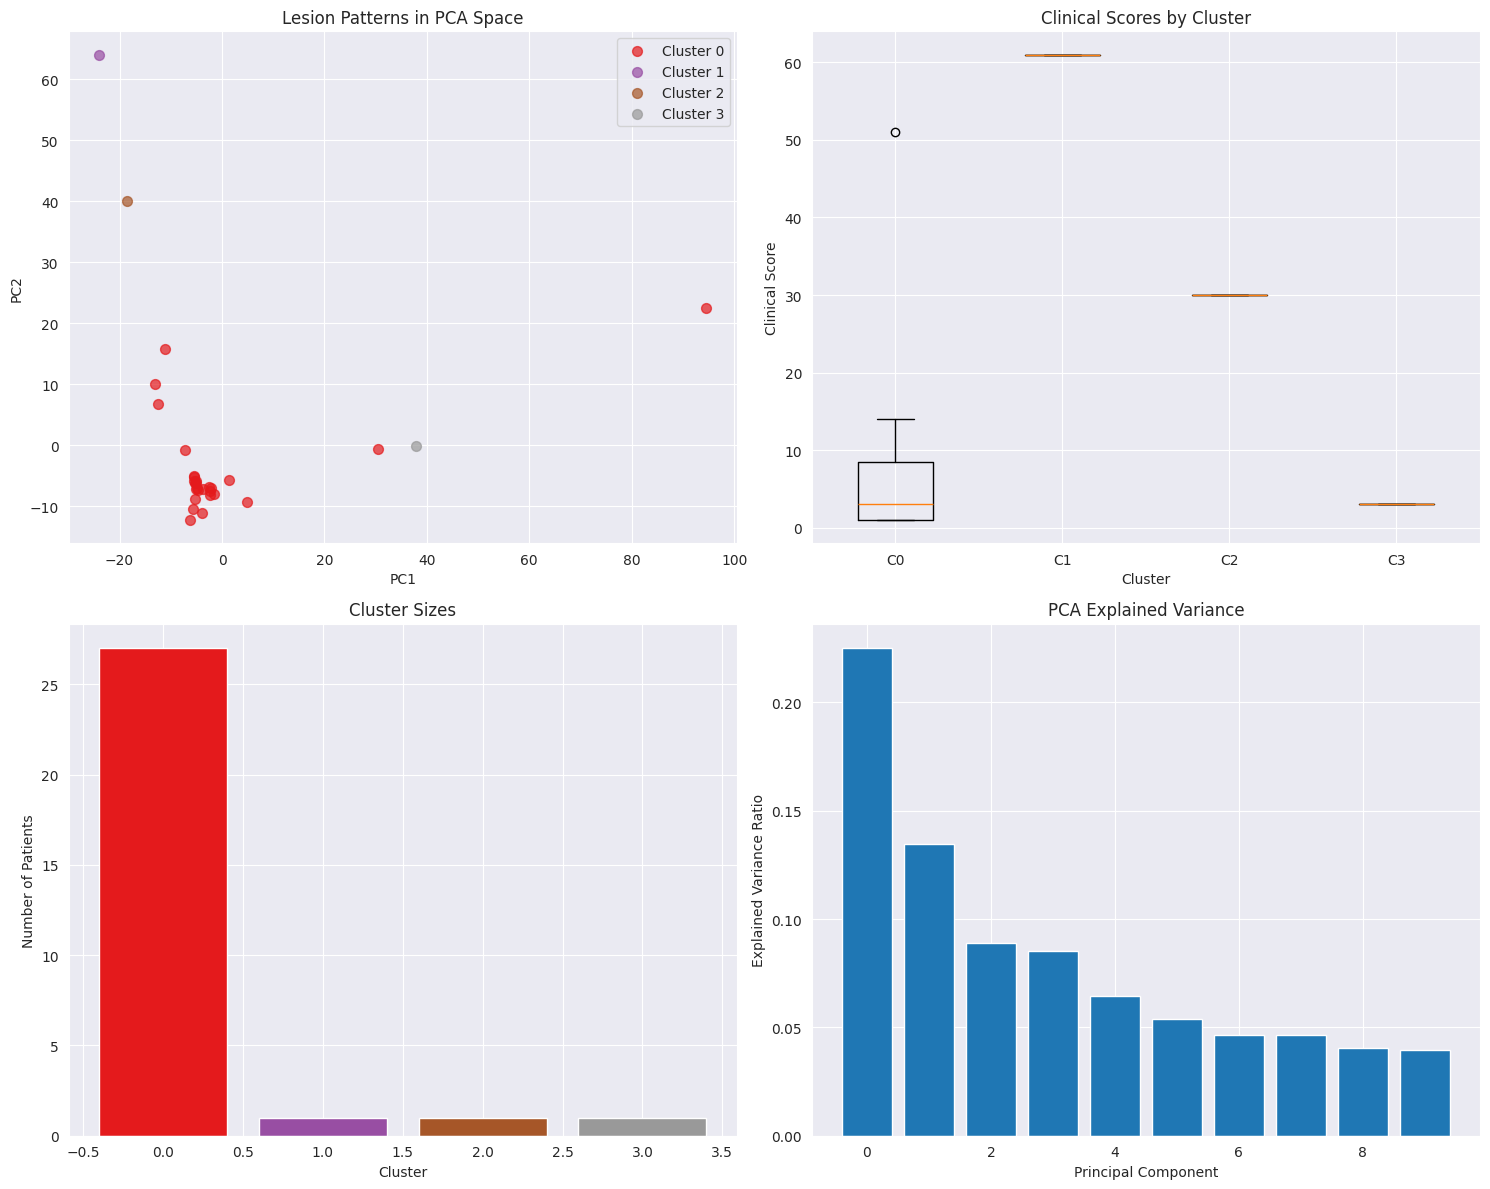


Cluster Statistics:
        Clinical score            
                  mean   std count
Cluster                           
0                  6.3  9.79    27
1                 61.0   NaN     1
2                 30.0   NaN     1
3                  3.0   NaN     1


In [8]:
# Visualize clustering results
if clustering_df is not None:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # PCA scatter plot
    colors = plt.cm.Set1(np.linspace(0, 1, n_clusters))
    for i in range(n_clusters):
        mask = cluster_labels == i
        axes[0, 0].scatter(
            lesion_pca[mask, 0],
            lesion_pca[mask, 1],
            c=[colors[i]],
            label=f"Cluster {i}",
            alpha=0.7,
            s=50,
        )

    axes[0, 0].set_xlabel("PC1")
    axes[0, 0].set_ylabel("PC2")
    axes[0, 0].set_title("Lesion Patterns in PCA Space")
    axes[0, 0].legend()

    # Clinical scores by cluster
    cluster_clinical = [
        clustering_df[clustering_df["Cluster"] == i]["Clinical score"].values
        for i in range(n_clusters)
    ]

    axes[0, 1].boxplot(cluster_clinical, labels=[f"C{i}" for i in range(n_clusters)])
    axes[0, 1].set_xlabel("Cluster")
    axes[0, 1].set_ylabel("Clinical Score")
    axes[0, 1].set_title("Clinical Scores by Cluster")

    # Cluster sizes
    cluster_sizes = np.bincount(cluster_labels)
    axes[1, 0].bar(range(n_clusters), cluster_sizes, color=colors)
    axes[1, 0].set_xlabel("Cluster")
    axes[1, 0].set_ylabel("Number of Patients")
    axes[1, 0].set_title("Cluster Sizes")

    # PCA explained variance
    axes[1, 1].bar(
        range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_
    )
    axes[1, 1].set_xlabel("Principal Component")
    axes[1, 1].set_ylabel("Explained Variance Ratio")
    axes[1, 1].set_title("PCA Explained Variance")

    plt.tight_layout()
    plt.show()

    # Cluster statistics
    cluster_stats = (
        clustering_df.groupby("Cluster")
        .agg({"Clinical score": ["mean", "std", "count"]})
        .round(2)
    )

    print("\nCluster Statistics:")
    print(cluster_stats)

else:
    print("Cannot perform clustering visualization - insufficient data")

## Statistical Analysis of Lesion-Deficit Relationships

Analyzing lesion-deficit relationships...
Volume-Clinical Score Correlation: r=0.744, p=0.0000
ANOVA for volume differences across severity: F=34.708, p=0.0000


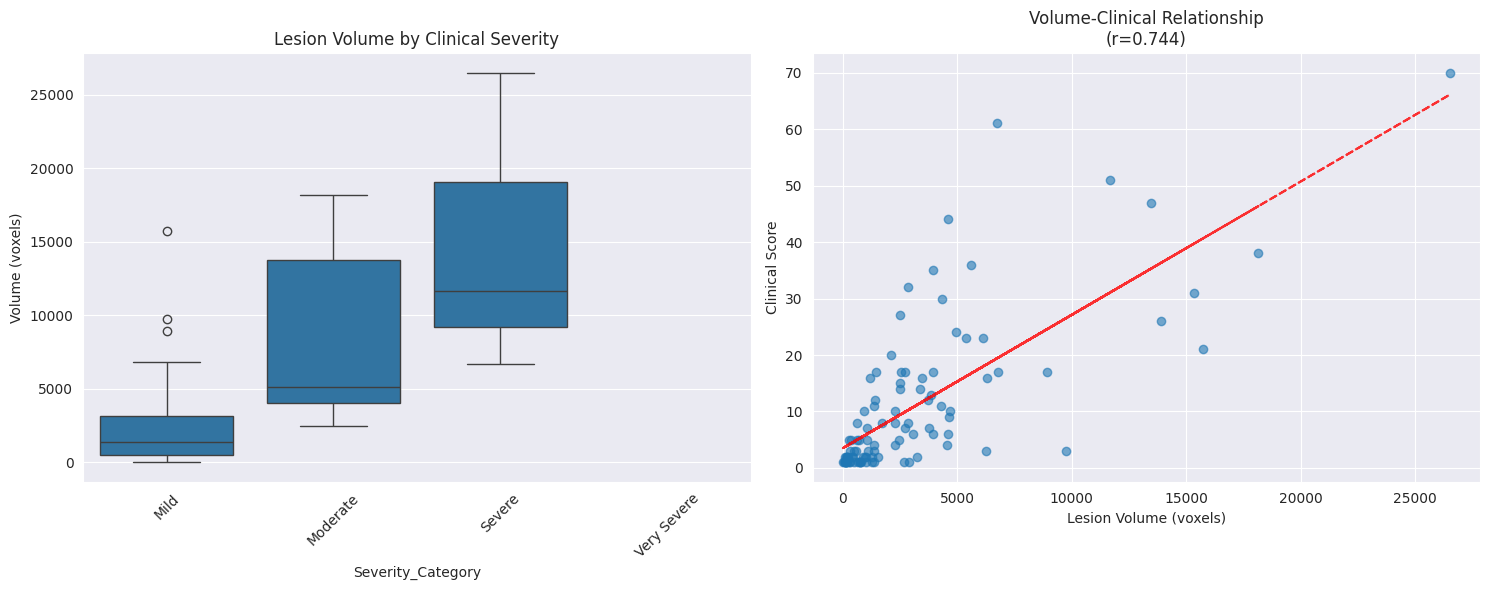

In [9]:
# Analyze relationship between lesion characteristics and deficits
print("Analyzing lesion-deficit relationships...")

if len(volume_analysis_df) > 10:

    # Volume-deficit correlation analysis
    volume_clinical_corr = stats.pearsonr(
        volume_analysis_df["volume"], volume_analysis_df["Clinical score"]
    )
    print(
        f"Volume-Clinical Score Correlation: r={volume_clinical_corr[0]:.3f}, p={volume_clinical_corr[1]:.4f}"
    )

    # Categorize patients by clinical severity
    volume_analysis_df["Severity_Category"] = pd.cut(
        volume_analysis_df["Clinical score"],
        bins=[0, 25, 50, 75, 100],
        labels=["Mild", "Moderate", "Severe", "Very Severe"],
    )

    # ANOVA test for volume differences across severity categories
    severity_groups = [
        volume_analysis_df[volume_analysis_df["Severity_Category"] == cat][
            "volume"
        ].values
        for cat in ["Mild", "Moderate", "Severe", "Very Severe"]
        if len(volume_analysis_df[volume_analysis_df["Severity_Category"] == cat]) > 0
    ]

    if len(severity_groups) > 1:
        f_stat, p_value = stats.f_oneway(*severity_groups)
        print(
            f"ANOVA for volume differences across severity: F={f_stat:.3f}, p={p_value:.4f}"
        )

    # Visualize severity analysis
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Volume by severity category
    severity_data = volume_analysis_df.dropna(subset=["Severity_Category"])
    if len(severity_data) > 0:
        sns.boxplot(data=severity_data, x="Severity_Category", y="volume", ax=axes[0])
        axes[0].set_title("Lesion Volume by Clinical Severity")
        axes[0].set_ylabel("Volume (voxels)")
        axes[0].tick_params(axis="x", rotation=45)

    # Scatter plot with trend line
    axes[1].scatter(
        volume_analysis_df["volume"], volume_analysis_df["Clinical score"], alpha=0.6
    )

    # Add trend line
    z = np.polyfit(
        volume_analysis_df["volume"], volume_analysis_df["Clinical score"], 1
    )
    p = np.poly1d(z)
    axes[1].plot(
        volume_analysis_df["volume"], p(volume_analysis_df["volume"]), "r--", alpha=0.8
    )

    axes[1].set_xlabel("Lesion Volume (voxels)")
    axes[1].set_ylabel("Clinical Score")
    axes[1].set_title(
        f"Volume-Clinical Relationship\n(r={volume_clinical_corr[0]:.3f})"
    )

    plt.tight_layout()
    plt.show()

else:
    print("Insufficient data for statistical analysis")

## Regional Analysis

Analyzing regional lesion distribution...


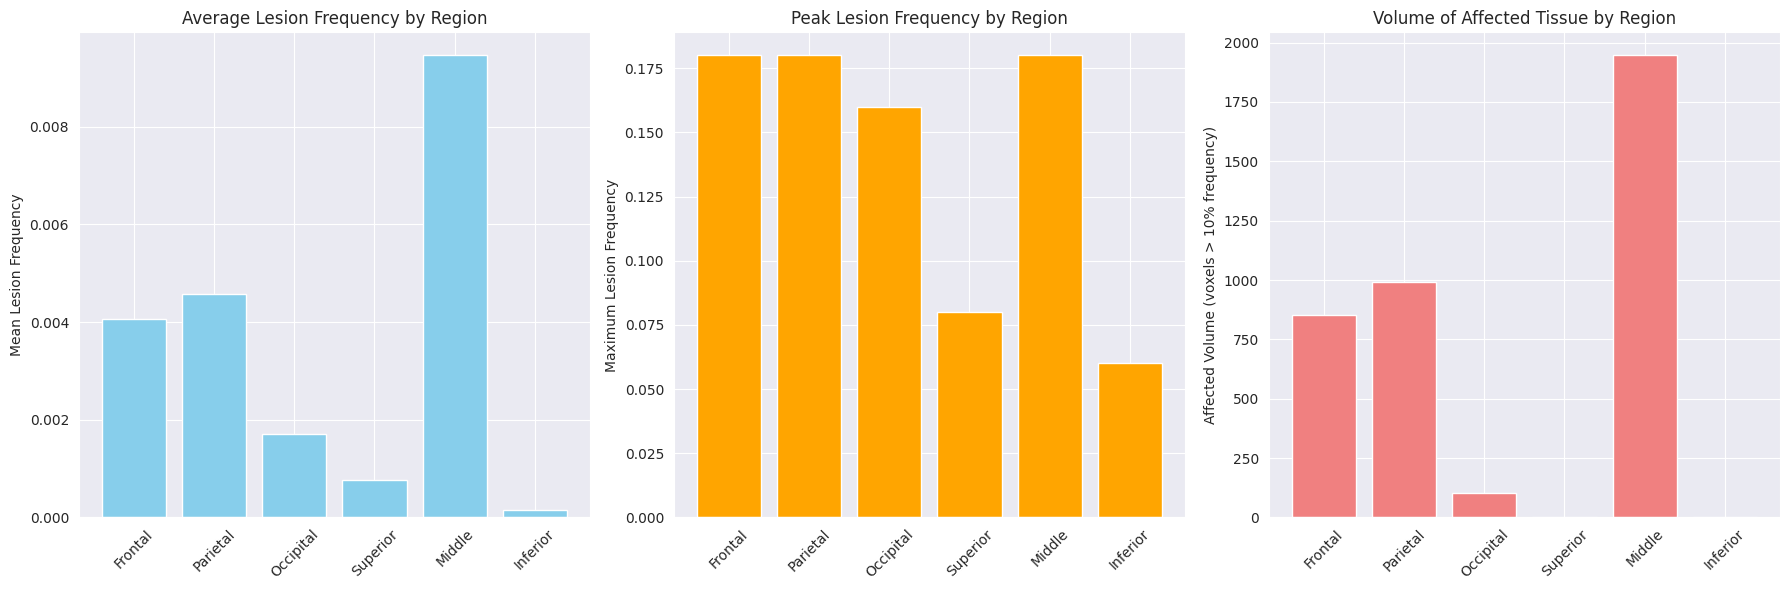


Regional Analysis Summary:
Frontal: Mean freq=0.0041, Max freq=0.1800, Affected volume=853 voxels
Parietal: Mean freq=0.0046, Max freq=0.1800, Affected volume=990 voxels
Occipital: Mean freq=0.0017, Max freq=0.1600, Affected volume=103 voxels
Superior: Mean freq=0.0008, Max freq=0.0800, Affected volume=0 voxels
Middle: Mean freq=0.0095, Max freq=0.1800, Affected volume=1946 voxels
Inferior: Mean freq=0.0001, Max freq=0.0600, Affected volume=0 voxels


In [10]:
# Analyze lesion distribution in different brain regions
print("Analyzing regional lesion distribution...")

if valid_count > 0:
    # Define rough brain regions based on MNI coordinates
    # This is a simplified regional analysis

    brain_regions = {
        "Frontal": frequency_map[:30, :, :],
        "Parietal": frequency_map[30:60, :, :],
        "Occipital": frequency_map[60:, :, :],
        "Superior": frequency_map[:, :, 60:],
        "Middle": frequency_map[:, :, 30:60],
        "Inferior": frequency_map[:, :, :30],
    }

    # Calculate regional frequencies
    regional_stats = {}
    for region, region_data in brain_regions.items():
        regional_stats[region] = {
            "mean_frequency": np.mean(region_data),
            "max_frequency": np.max(region_data),
            "volume_affected": np.sum(region_data > 0.1),  # Voxels with >10% frequency
            "total_volume": region_data.size,
        }

    # Create regional analysis plot
    regions = list(regional_stats.keys())
    mean_freqs = [regional_stats[r]["mean_frequency"] for r in regions]
    max_freqs = [regional_stats[r]["max_frequency"] for r in regions]
    affected_volumes = [regional_stats[r]["volume_affected"] for r in regions]

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Mean frequency by region
    axes[0].bar(regions, mean_freqs, color="skyblue")
    axes[0].set_ylabel("Mean Lesion Frequency")
    axes[0].set_title("Average Lesion Frequency by Region")
    axes[0].tick_params(axis="x", rotation=45)

    # Maximum frequency by region
    axes[1].bar(regions, max_freqs, color="orange")
    axes[1].set_ylabel("Maximum Lesion Frequency")
    axes[1].set_title("Peak Lesion Frequency by Region")
    axes[1].tick_params(axis="x", rotation=45)

    # Affected volume by region
    axes[2].bar(regions, affected_volumes, color="lightcoral")
    axes[2].set_ylabel("Affected Volume (voxels > 10% frequency)")
    axes[2].set_title("Volume of Affected Tissue by Region")
    axes[2].tick_params(axis="x", rotation=45)

    plt.tight_layout()
    plt.show()

    # Print regional statistics
    print("\nRegional Analysis Summary:")
    for region, stats in regional_stats.items():
        print(
            f"{region}: Mean freq={stats['mean_frequency']:.4f}, "
            f"Max freq={stats['max_frequency']:.4f}, "
            f"Affected volume={stats['volume_affected']} voxels"
        )
else:
    print("No frequency data available for regional analysis")

## Summary and Insights

This notebook performed advanced lesion pattern analysis. Key findings from this analysis:

### Volume Analysis
- Examined the relationship between lesion volume and clinical severity
- Calculated volume statistics and distributions
- Assessed volume differences across treatment groups

### Population Patterns
- Created frequency maps showing common lesion locations
- Identified regions most frequently affected in the population
- Analyzed regional distribution patterns

### Pattern Clustering
- Grouped patients with similar lesion patterns using machine learning
- Used PCA for dimensionality reduction and K-means for clustering
- Analyzed clinical characteristics of different pattern clusters

### Statistical Relationships
- Tested correlations between lesion characteristics and clinical outcomes
- Performed ANOVA to test for differences across severity groups
- Analyzed regional frequency patterns

**Next Steps:**
1. Use findings to inform feature engineering for machine learning models
2. Investigate treatment response patterns (notebook 03)
3. Apply insights to the three main tasks: prediction, prescription, and inference

**Important Notes:**
- This analysis used subsets of data for computational efficiency
- Full dataset analysis may reveal additional patterns
- Consider using the Streamlit app for interactive exploration of full dataset

In [11]:
# Save analysis results for future use
analysis_results = {
    "volume_statistics": {
        "mean_volume": np.mean(volumes) if len(volumes) > 0 else None,
        "median_volume": np.median(volumes) if len(volumes) > 0 else None,
        "volume_clinical_correlation": (
            correlation if len(volume_analysis_df) > 0 else None
        ),
        "n_analyzed": len(volumes),
    },
    "clustering_results": {
        "n_clusters": n_clusters if clustering_df is not None else None,
        "n_clustered_patients": (
            len(clustering_df) if clustering_df is not None else None
        ),
        "clustering_successful": clustering_df is not None,
    },
    "population_analysis": {
        "n_patients_in_frequency_map": valid_count,
        "max_frequency": np.max(frequency_map) if valid_count > 0 else None,
        "affected_voxels": np.sum(frequency_map > 0) if valid_count > 0 else None,
    },
}

print("\nAnalysis Summary:")
for category, results in analysis_results.items():
    print(f"\n{category.upper()}:")
    for key, value in results.items():
        print(f"  {key}: {value}")


Analysis Summary:

VOLUME_STATISTICS:
  mean_volume: 3227.17
  median_volume: 1642.0
  volume_clinical_correlation: 0.7436426958599318
  n_analyzed: 100

CLUSTERING_RESULTS:
  n_clusters: 4
  n_clustered_patients: 30
  clustering_successful: True

POPULATION_ANALYSIS:
  n_patients_in_frequency_map: 50
  max_frequency: 0.18
  affected_voxels: 74336
